In [ ]:
#default_exp core

# rfpfolio

> Create portfolios with rebalancing, and measure performance.

In [ ]:
#hide
from nbdev.showdoc import show_doc
from fastcore.test import *
from nbdev.export import notebook2script

## Load Price Data

In [ ]:
#export
import pandas as pd
import numpy as np
import array
import os.path
import glob
from dataclasses import dataclass
from datetime import datetime
from typing import List
from typing import NamedTuple

In [ ]:
#export
class PriceSource:
    
    def __init__(self, data_root, subdir_default='weekly'):
        """
        Args:
            - data_root (str): Relative or absolute path to the root directory to load data from.
            - In the root should be one or more directories named 'weekly', 'monthly', etc.
        """
        self.data_root = os.path.abspath(data_root)
        self.subdir_default = subdir_default
        
    def __repr__(self):
        return (self.__class__.__qualname__ + f"(data_root={self.data_root})")
    
    def list_return_dates(self, subdir=None):
        """
        Print the range of return dates available for each csv file in the specified directory.
        """
        subdir =  subdir if subdir is not None else self.subdir_default
        glob_path = os.path.join(self.data_root, subdir, '*.csv')
        for path in glob.iglob(glob_path):
            prices = pd.read_csv(path, parse_dates=[0])
            start_date = prices.Date.iloc[0].date().isoformat()
            end_date = prices.Date.iloc[-1].date().isoformat()
            print(f"{start_date} => {end_date}  {os.path.basename(path)}")
            
    def loadAdjustedPrices(self, ticker, subdir=None):
        """
        Load data in to single column dataframe, indexed by date.
        The column has the name of the ticker, and is the adjusted price.
        Note: for Yahoo weekly data, the adj price is the adjusted closing price for the 
        week beginning on the specified date.
        
        Args:
            - ticker (str): Name of file to load, without '.csv' extension.
            - subdir (str): Subdir of data_root wherein to find file to load.
            
        Returns:
            - A dataframe with the specified data, indexed by date.
        """
        subdir =  subdir if subdir is not None else self.subdir_default
        csv_path =  os.path.join(self.data_root, subdir, f"{ticker}.csv")
        prices = pd.read_csv(csv_path, parse_dates=[0])
        prices = prices[['Date', 'Adj Close']]
        prices.columns = ['Date', ticker]
        return prices.set_index('Date')
    
    
    def loadAllAdjustedPrices(self, tik_list, subdir=None):
        """
        Load adjusted price data for all tickers to a dataframe, indexed by date.
        Each column name is a ticker, and the column values are the sequence of adjusted prices.
        
        Returns:
            - A dataframe with the specified data, indexed by date.
        """
        subdir =  subdir if subdir is not None else self.subdir_default
        tik_dict = {tik:  self.loadAdjustedPrices(tik, subdir) for tik in tik_list}
        return pd.concat([tik_dict[tik] for tik in tik_list], axis=1, join='inner')
    
    def load_period_returns_ticker(self, ticker, subdir=None):
        """Submethod of load_period_returns(). Load period returns for an asset."""
        subdir =  subdir if subdir is not None else self.subdir_default
        df = self.loadAdjustedPrices(ticker, subdir)
        return df.pct_change().dropna()
    
    def load_period_returns(self, spec, subdir=None):
        """Load period returns for an asset, or a specified temporal sequence of assets.
        
        Args:
            - spec: Specifier of asset price data to load. Either a string (filename) or SpliceSpec
            - subdir: subdirectory of root to find data. Usual convention is to specify interval: 
            'daily', 'weekly', 'monthly'
            - name: name for this asset return sequence (will be DataFrame's column name)
            
        Returns:
            - DataFrame of period returns for asset (or asset sequence) described by `spec`.
        """
        
        def date_selector(df, start, end):
            """Return a selector (boolean ndarray) of df for the specified start and end date. 
            Selected rows have date index >= `start` and < `end`.
            """
            if start is None and end is None:
                # all rows
                return np.full(df.shape[0], True)
            elif start is None:
                return df.index < end
            elif end is None:
                return df.index >= start
            else:
                return (df.index >= start) & (df.index < end)
            
        subdir =  subdir if subdir is not None else self.subdir_default
        if isinstance(spec, str):
            return self.load_period_returns_ticker(spec, subdir)
        
        else:
            assert isinstance(spec, SpliceSpec)
            
            # with start_list = [d0, d1, d2], resulting date intervals are [d0, d1), [d1, d2), [d2, ..)
            start_list = [x.start for x in spec.sequence]
            df_seq = (self.load_period_returns_ticker(x.fname, subdir) for x in spec.sequence)
            
            # ... start_list, start_list[1:]+[None] -- this produces desired date intervals
            sub_dfs = [df[date_selector(df, start, end)] for df, start, end in zip(df_seq, start_list, start_list[1:]+[None])]
            
            # give the column of all sub_dfs the same name
            for df in sub_dfs:
                df.columns = [spec.name]
                
            return pd.concat(sub_dfs)

In [ ]:
# Is this needed to show the doc for methods?
for elt in '__init__ list_return_dates load_period_returns loadAdjustedPrices loadAllAdjustedPrices'.split():
    show_doc(eval('PriceSource.'+elt))

<h4 id="PriceSource.__init__" class="doc_header"><code>PriceSource.__init__</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>PriceSource.__init__</code>(**`data_root`**, **`subdir_default`**=*`'weekly'`*)

Args:
    - data_root (str): Relative or absolute path to the root directory to load data from.
    - In the root should be one or more directories named 'weekly', 'monthly', etc.

<h4 id="PriceSource.list_return_dates" class="doc_header"><code>PriceSource.list_return_dates</code><a href="__main__.py#L37" class="source_link" style="float:right">[source]</a></h4>

> <code>PriceSource.list_return_dates</code>(**`subdir`**=*`None`*)

Print the range of return dates available for each csv file in the specified directory.

<h4 id="PriceSource.load_period_returns" class="doc_header"><code>PriceSource.load_period_returns</code><a href="__main__.py#L66" class="source_link" style="float:right">[source]</a></h4>

> <code>PriceSource.load_period_returns</code>(**`spec`**, **`subdir`**=*`None`*)

Load period returns for an asset, or a specified temporal sequence of assets.

Args:
    - spec: Specifier of asset price data to load. Either a string (filename) or SpliceSpec
    - subdir: subdirectory of root to find data. Usual convention is to specify interval: 
    'daily', 'weekly', 'monthly'
    - name: name for this asset return sequence (will be DataFrame's column name)
    
Returns:
    - DataFrame of period returns for asset (or asset sequence) described by `spec`.

<h4 id="PriceSource.loadAdjustedPrices" class="doc_header"><code>PriceSource.loadAdjustedPrices</code><a href="__main__.py#L16" class="source_link" style="float:right">[source]</a></h4>

> <code>PriceSource.loadAdjustedPrices</code>(**`ticker`**, **`subdir`**=*`None`*)

Load data in to single column dataframe, indexed by date.
The column has the name of the ticker, and is the adjusted price.
Note: for Yahoo weekly data, the adj price is the adjusted closing price for the 
week beginning on the specified date.

Args:
    - ticker (str): Name of file to load, without '.csv' extension.
    - subdir (str): Subdir of data_root wherein to find file to load.
    
Returns:
    - A dataframe with the specified data, indexed by date.

<h4 id="PriceSource.loadAllAdjustedPrices" class="doc_header"><code>PriceSource.loadAllAdjustedPrices</code><a href="__main__.py#L49" class="source_link" style="float:right">[source]</a></h4>

> <code>PriceSource.loadAllAdjustedPrices</code>(**`tik_list`**, **`subdir`**=*`None`*)

Load adjusted price data for all tickers to a dataframe, indexed by date.
Each column name is a ticker, and the column values are the sequence of adjusted prices.

Returns:
    - A dataframe with the specified data, indexed by date.

Here is an example of loading some weekly adjusted price data:

In [ ]:
tst_src = PriceSource('testdata/2017-Apr')

We can see what data files are available in subdirectory, and their date coverage.

In [ ]:
tst_src.list_return_dates('weekly')

2017-03-27 => 2020-05-25  AGG.csv
2017-04-03 => 2020-06-29  GLD.csv
2017-04-03 => 2020-06-29  IEI.csv
2017-04-03 => 2020-06-29  PDBC.csv
2017-04-03 => 2020-06-29  SHV.csv
2017-04-03 => 2020-06-29  SPY.csv
2017-04-03 => 2020-06-29  TLT.csv
2017-03-27 => 2020-05-25  VT.csv
2017-04-03 => 2020-06-29  VTI.csv


In [ ]:
price_data = tst_src.loadAllAdjustedPrices(['SPY', 'IEI', 'GLD'])
price_data.head()

,SPY,IEI,GLD
Date,,,
2017-04-03,220.896225,115.845558,119.459999
2017-04-10,218.369843,116.867851,122.599998
2017-04-17,220.323349,116.943314,122.309998
2017-04-24,223.601120,116.688652,120.769997
2017-05-01,225.122589,116.301956,117.010002


In [ ]:
#hide
# top 5 rows of data
spy_5 = price_data.loc[:'2017-05-01', 'SPY']
test_close(list(spy_5), [220.896225, 218.369843, 220.323349, 223.60112, 225.122589])

iei_5 = price_data.loc[:'2017-05-01', 'IEI']
test_close(list(iei_5), [115.845558, 116.867851, 116.943314, 116.688652, 116.301956])

gld_5 = price_data.loc[:'2017-05-01', 'GLD']
test_close(list(gld_5), [119.459999, 122.599998, 122.309998, 120.769997, 117.010002])

# last row of data
last = price_data.iloc[-1:,:]
# 2020-06-29 data for spy, iei, gld
last.to_numpy()[0] = np.array([310.519989, 133.316208, 166.619995])

`load_period_returns()` will return the period returns for an asset, rather than adjusted prices.

In [ ]:
return_data = tst_src.load_period_returns('GLD', 'weekly')
return_data.head()

,GLD
Date,
2017-04-10,0.026285
2017-04-17,-0.002365
2017-04-24,-0.012591
2017-05-01,-0.031134
2017-05-08,-0.001538


### Load Return Data from Spliced Data Sources

When period returns are loaded (using method `load_period_returns()`) there is an option of specifying a sequence of data sources that are spliced together. This feature was originally added to support combining data sets from multiple sources to represent the performance of one asset class. This was needed when a single source of data did not cover the entire period of interest.

The following classes `SpliceSpec` and `PSeg` are used to describe sequences of data to splice together.

In [ ]:
#export

@dataclass(frozen=True)
class PSeg:
    """Asset filename and start date -- used to specify sequential concatenations of various asset prices.
    """
    fname: str
    start: str
        
    def __post_init__(self):
        if self.start is None:
            return
        if not (isinstance(self.start, str) or isinstance(self.start, datetime)):
            raise ValueError("The date field must be a string or datetime")
        # confirm that the 'date' string can be converted to a pd.Timestamp
        pd.Timestamp(self.start)
        
    def __repr__(self):
        # Show how the date string will be interpreted as by pd.Timestamp -- e.g., '2015'
        # will be interpreted as the first day of the year, '2015-01-01'.
        date_str = pd.Timestamp(self.start).date().isoformat()
        return f"{self.__class__.__qualname__}(fname={self.fname}, start={date_str})"
    
    
class SpliceSpec(NamedTuple):
    """Specification for a data source created from a sequence of asset prices.
    
    Fields:
        - name: a name for the sequence
        - sequence: a list of PSeg, indicating a sequence of asset price segments
    """
    name: str
    sequence: List[PSeg]

Here is an example of loading period returns from a sequence of spliced data sources.

In [ ]:
spec1 = SpliceSpec('Combined', [PSeg('SHV', None), PSeg('SPY', '2018-06')])
res = tst_src.load_period_returns(spec1, subdir='weekly')

# Note volatility of SHV is much lower than SPY, so you can easily see where the returns are spliced.
res1 = res.loc['2018-05-14':'2018-07-02']
res1

,Combined
Date,
2018-05-14,0.000272
2018-05-21,0.000544
2018-05-28,-0.001087
2018-06-04,0.016776
2018-06-11,-0.003810
2018-06-18,-0.004172
2018-06-25,-0.012594
2018-07-02,0.015261


In [ ]:
#hide
# For test:
# load price data for comparison
tst_prices = tst_src.loadAllAdjustedPrices(['SHV', 'SPY'], 'weekly').loc['2018-05':'2018-07-02']

# Compute period returns for each of SHV, SPY
tst_returns = tst_prices.pct_change().dropna()
tst_returns

,SHV,SPY
Date,,
2018-05-14,0.000272,-0.005571
2018-05-21,0.000544,0.003022
2018-05-28,-0.001087,0.005328
2018-06-04,0.001524,0.016776
2018-06-11,0.000363,-0.003810
2018-06-18,0.000453,-0.004172
2018-06-25,0.000453,-0.012594
2018-07-02,-0.001087,0.015261


In [ ]:
#hide
# verify values of result are as expected -- 
# SHV returns through 2018-05
assert np.array_equal(res1.Combined.loc[:'2018-05'].values, tst_returns.SHV.loc[:'2018-05'].values)
# SPY returns from 2018-06
assert np.array_equal(res1.Combined.loc['2018-06':].values, tst_returns.SPY.loc['2018-06':].values)

## Compute Returns

In [ ]:
#export
def period_returns_from_prices(tik_prices, wr=False):
    """
    Given one or more sequences of prices, compute the returns over each adjacent pair of rows.
    Returns a dataframe containing period returns with row count one less than `tik_prices`.
    
    NOTE: You can also simply do: tik_prices.pct_change() for percent returns, or 
    tik_prices.pct_change() + 1 for wealth ratios.
    
    Arguments:
        tik_prices: DataFrame of ordered prices: ticker column names, rows indexed by date
        wr: if true, returns are represented as wealth ratios (1.01 <=> 1% return), else as 
        fractional returns (0.01 <=> 1% return)
    """
    prices = tik_prices.to_numpy()
    # 1st row of ratios is 2nd row of prices divided by first, & so forth
    ratios = prices[1:] / prices[:-1]
    returns = ratios - 1
    return pd.DataFrame(ratios if wr else returns, index=tik_prices.index[1:], columns=tik_prices.columns)

Create some example data to demonstrate usage of `period_returns_from_prices()`:

In [ ]:
# An easy way to get a datetime index
spy_wk = tst_src.loadAdjustedPrices('SPY')

# These values are ajdusted prices
xmpl_data = pd.DataFrame({'A': [1.0, 1.01, 1.0],
                          'B': [1.0, 1.02, 1.1]},
                         index = spy_wk.index[4:7])
xmpl_data

,A,B
Date,,
2017-05-01,1.00,1.00
2017-05-08,1.01,1.02
2017-05-15,1.00,1.10


Compute period returns.

In [ ]:
per_rets = period_returns_from_prices(xmpl_data)
per_rets

,A,B
Date,,
2017-05-08,0.010000,0.020000
2017-05-15,-0.009901,0.078431


Compute period returns as wealth ratios.

In [ ]:
per_rets_wr = period_returns_from_prices(xmpl_data, wr=True)
per_rets_wr

,A,B
Date,,
2017-05-08,1.010000,1.020000
2017-05-15,0.990099,1.078431


In [ ]:
#hide

# Automated Tests

# period returns
res1 = period_returns_from_prices(xmpl_data)
test_eq(res1.iloc[0, 0], 1.01 / 1.0 - 1)
test_eq(res1.iloc[1, 0], 1.00 / 1.01 - 1)
test_eq(res1.iloc[0, 1], 1.02 / 1.0 - 1)
test_eq(res1.iloc[1, 1], 1.1 / 1.02 - 1)

# wealth ratios
res1 = period_returns_from_prices(xmpl_data, wr=True)
test_eq(res1.iloc[0, 0], 1.01 / 1.0)
test_eq(res1.iloc[1, 0], 1.00 / 1.01)
test_eq(res1.iloc[0, 1], 1.02 / 1.0)
test_eq(res1.iloc[1, 1], 1.1 / 1.02)

In [ ]:
#exporti
# Internal use: used in computation of portfolio returns.

def cum_wr_to_period_returns(cum_wr_ar, use_log = False):
    """
    Convert 1D array of cumulative wealth ratios to period fractional returns (0.01 = 1% return)
    The first element of `cum_wr_ar` is the wealth ratio for the corresponding period. (e.g., the first
    element will be 1.01 if the corresponding period return is 1%.)
    
    Cumulative wealth ratios are used in the computation of rebalanced portfolio returns; use this 
    to convert from portfolio cumulative wr to portfolio period returns.
    
    Arguments:
        cum_wr_ar: numpy array - dim 0 is time
        
    Return: 
        numpy array of period returns
    """
    # add initial 1 so the ratio of `cum_wr_ar` offset by one with itself will be period returns
    row1 = np.array([1.0])
    ar_plus = np.concatenate([row1, cum_wr_ar], axis=0)
    
    if use_log:
        return np.exp(np.log(ar_plus[1:]) - np.log(ar_plus[:-1])) - 1
    else:
        return ar_plus[1:] / ar_plus[:-1] - 1

In [ ]:
#hide
# Example data to show usage of `cum_wr_to_period_returns()`
per_rets_wr

,A,B
Date,,
2017-05-08,1.010000,1.020000
2017-05-15,0.990099,1.078431


In [ ]:
#hide
# compute cumulative returns for input to cum_wr_to_period_returns
cum_rets = np.cumprod(per_rets_wr, axis=0)
cum_rets

,A,B
Date,,
2017-05-08,1.01,1.02
2017-05-15,1.00,1.10


In [ ]:
#hide
per_rets_A = cum_wr_to_period_returns(cum_rets['A'])
per_rets_A

array([ 0.01      , -0.00990099])

In [ ]:
#hide
# verify result of cum_wr_to_period_returns is equal to original period returns
test_eq(cum_wr_to_period_returns(cum_rets['A']), per_rets['A'])
test_eq(cum_wr_to_period_returns(cum_rets['B']), per_rets['B'])

## Portfolio Returns

In [ ]:
#exporti
def pf_cum_wr_seq(price_df, weights, rebal_period, normalize_wts=False):
    """
    Compute the sequence of cumulative portfolio wealth ratios from a sequence of asset prices, with 
    rebalancing at a fixed interval. 
    
    Args:
        price_df: Dataframe of asset returns as (noncumulative) wealth ratios, indexed by date
        weights [list]: portfolio weights for each asset ordered the same as columns of `price_df`
        rebal_period: length of the rebalance period, expressed in number of rows of `price_df`
        
    Returns:
        A python (double) array containing the sequence of portfolio values (cumulative wealth ratios)
    """
    # weights, as a 1-row 2D matrix
    weight_ar = np.array([weights])
    
    if normalize_wts:
        weight_ar = weight_ar / weight_ar.sum()
    
    # cols: wr's for a ticker.  rows: dates
    returns = price_df.to_numpy()
    
    period_start_ind = 0
    pf_val = 1
    
    # list of pf values:
    pf_values = array.array('d')
    
    while (period_start_ind < returns.shape[0]):
        # first row of array for cumprod is the initial capital per asset
        row_1 = weight_ar * pf_val
        
        # get the data for the next rebalance period
        rebal_period_return_data = returns[period_start_ind:period_start_ind+rebal_period]
        
        # Result of this operation: first row is initial capital per asset after rebalancing; 
        # each subsequent row is the capital at subsequent dates
        ar_for_cumprod = np.append(row_1, rebal_period_return_data, axis=0)
        asset_values = np.cumprod(ar_for_cumprod, axis=0)
        
        # Compute sequence of portfolio values: sum of columns (asset vals) for each row.
        # Drop first value as it was the sum of the intitializing values (asset values).
        pf_rebal_period_values = np.sum(asset_values, axis=1)[1:]
        
        # append portfolio values for the rebalancing period to `pf_values`
        pf_values.extend(pf_rebal_period_values)
        
        # portfolio value at the end of the rebal period; use to compute starting capital
        # for each asset at the start of the next rebalancing period.
        pf_val = pf_rebal_period_values[-1]
        
        period_start_ind += rebal_period
        
    return pf_values

In [ ]:
#export
def pf_period_returns(price_df, weights, rebal_period, pf_name, pf_start_val = 1, normalize_wts=False):
    """
    Compute the sequence of portfolio period returns from a sequence of asset prices, with rebalancing 
    at a fixed interval.
    
    Arguments:
        price_df: Dataframe of asset returns as (noncumulative) wealth ratios, indexed by date
        weights: portfolio weights for each asset ordered the same as columns of `price_df`
        pf_name: name for this portfolio -- will appear as column name
        rebal_period: length of the rebalance period, expressed in number of rows of `price_df`
        
    Returns:
        A DataFrame containing the sequence of portfolio period returns
    """
    # Compute portfolio cumulative wealth ratios (with rebalancing).
    pf_val_ar = np.asarray(pf_cum_wr_seq(price_df, weights, rebal_period, normalize_wts))
    
    # Cumulative wealth ratios to period returns
    pf_ret_ar = cum_wr_to_period_returns(pf_val_ar)
    
    return pd.DataFrame(pf_ret_ar, index=price_df.index, columns=[pf_name])

**Entry point for computing portfolio returns:**

In [ ]:
#export
def computePortfolioReturns(p_src: PriceSource, asset_weights, pf_name, rebal_period, 
                            period='weekly',start_date='2017-05-01', normalize_wts=True, wr=False):
    """
    Given tickers and their weights, compute the sequence of portfolio returns with rebalancing at the specified interval.
    
    Arguments:
        p_src
        asset_weights: dictionary from ticker to weight for this asset in pf (weights will)
        pf_name: name for this portfolio -- will appear as column name
        rebal_period: length of the rebalance period, expressed in number of rows of `price_df`
        period: 'weekly', or 'monthly'
        start_date: date of first period in sequence; first rebalance period begins with this period
        normalize_wts: if true, normalize weights to sum to 1
        wr: if False, returns expressed as period returns (value of 0.01 => 1% return) else as wealth ratios
        (value of 1.01 => 1% return)
        
    Returns:
        A DataFrame containing the sequence of portfolio returns , indexed by date.
    """
    adjPrices = p_src.loadAllAdjustedPrices(list(asset_weights.keys()), subdir=period)
    asset_returns = period_returns_from_prices(adjPrices, wr=True).loc[start_date:]
    
    per_returns = pf_period_returns(asset_returns, 
                             list(asset_weights.values()), 
                             rebal_period, 
                             pf_name, 
                             normalize_wts=normalize_wts).loc[start_date:]
    if wr:
        return 1 + per_returns
    else:
        return per_returns

**Entry Point that allows SpliceSpec**

In [ ]:
#export
def computePortfolioReturns2(p_src: PriceSource, asset_wt_list, pf_name, rebal_period, 
                            period=None, start_date=None, normalize_wts=True, wr=False):
    """
    Given asset specs and their weights, compute the sequence of portfolio returns with rebalancing at the specified interval.
    
    Arguments:
     - p_src: PriceSource for price data
     - asset_wt_list: list of (asset_spec, asset_weight)
     - pf_name: name for this portfolio -- will appear as column name
     - rebal_period: length of the rebalance period, expressed in number of rows of `price_df`
     - period: Either None, 'daily', 'weekly', or 'monthly'. If None, use `p_src` default.
     - start_date: None or date of first period in sequence; first rebalance period begins with this period.
       If None, use first date available for all assets.
     - normalize_wts: if true, normalize weights to sum to 1
     - wr: if False, returns expressed as period returns (value of 0.01 => 1% return) else as wealth ratios
        (value of 1.01 => 1% return)
        
    Returns:
        A DataFrame containing the sequence of portfolio returns , indexed by date.
    """
    all_period_returns = [p_src.load_period_returns(spec, period) for spec, _ in asset_wt_list]
    asset_returns = pd.concat(all_period_returns, axis=1, join='inner')
    # return asset_returns
    asset_returns = asset_returns + 1  # returns as wealth ratios
    if start_date:
        asset_returns = asset_returns.loc[start_date:]
    
    per_returns = pf_period_returns(asset_returns, 
                             [wt for _, wt in asset_wt_list], 
                             rebal_period, 
                             pf_name, 
                             normalize_wts=normalize_wts)
    if wr:
        return 1 + per_returns
    else:
        return per_returns

In [ ]:
src1 = PriceSource(r'..\data\TrendFollowing', subdir_default='monthly')

In [ ]:
commodities_spec = SpliceSpec('Commodities', [PSeg('crb_spot_adj_2_07', None), PSeg('dbiq_index', '1988-12-01')])
# Do the best we can with what's available
# - before 1980, just interm treasuries in place of long-term
# - after 1980, use Fidelity bond as stand-in for both parts of bond portfolio
# - TLT data starts in 2002 -- here we can follow actual prescribed allocation
lt_bond_spec =  SpliceSpec('LT_Bond', [PSeg('US10yr', None), PSeg('FBNDX', '1980-01'), PSeg('TLT', '2002-07')])
int_bond_spec = SpliceSpec('IT_Bond', [PSeg('US10yr', None), PSeg('FBNDX', '1980-01'), PSeg('US10yr', '2002-07')])

In [ ]:
asset_spec = [('^GSPC', 0.3), (int_bond_spec, .15), (lt_bond_spec, .40), (commodities_spec, .075), ('gold', 0.075)]
df = computePortfolioReturns2(src1, asset_spec, "All_Weather", 3)

In [ ]:
df.head(4)

,^GSPC,IT_Bond,LT_Bond,Commodities,gold
Date,,,,,
1970-03-01,0.001452,-0.006921,-0.006921,-0.008281,0.007995
1970-04-01,-0.090483,-0.044506,-0.044506,-0.027712,0.015581
1970-05-01,-0.060967,-0.002288,-0.002288,-0.044557,-0.011158
1970-06-01,-0.050033,0.025130,0.025130,0.012324,0.001128


In [ ]:
df.tail(4)

,^GSPC,IT_Bond,LT_Bond,Commodities,gold
Date,,,,,
2019-02-01,0.029729,-0.006445,-0.015987,0.028842,-0.003098
2019-03-01,0.017924,0.030352,0.055872,-0.004953,-0.018004
2019-04-01,0.039313,-0.006722,-0.020000,0.010310,-0.010113
2019-05-01,-0.065778,0.034994,0.068503,-0.058215,0.010333


In [ ]:
import empyrical.stats as estats
import matplotlib.pyplot as plt

%matplotlib inline

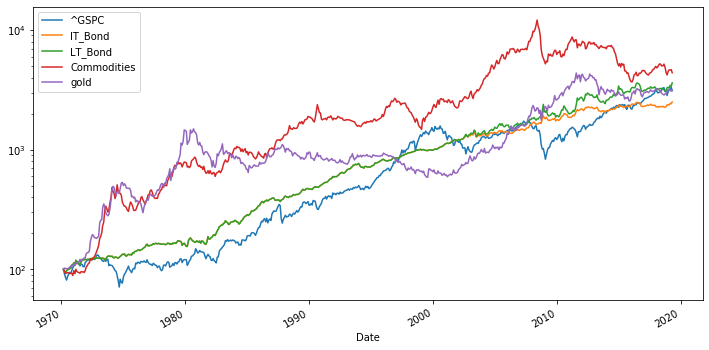

In [ ]:
estats.cum_returns(df, 100).plot.line(figsize=(12,6));
plt.yscale('log')

In [ ]:
df_pf = computePortfolioReturns2(src1, asset_spec, "All_Weather", 3)

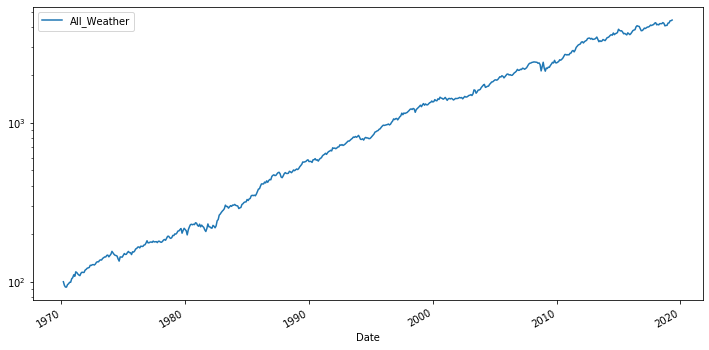

In [ ]:
estats.cum_returns(df_pf, 100).plot.line(figsize=(12,6));
plt.yscale('log')

In [ ]:
df_all = pd.concat([df, df_pf], axis=1, join='inner')
df_all.head()

,^GSPC,IT_Bond,LT_Bond,Commodities,gold,All_Weather
Date,,,,,,
1970-03-01,0.001452,-0.006921,-0.006921,-0.008281,0.007995,-0.003392
1970-04-01,-0.090483,-0.044506,-0.044506,-0.027712,0.015581,-0.052555
1970-05-01,-0.060967,-0.002288,-0.002288,-0.044557,-0.011158,-0.023227
1970-06-01,-0.050033,0.025130,0.025130,0.012324,0.001128,-0.000179
1970-07-01,0.073295,0.027237,0.027237,0.006742,-0.005354,0.036362


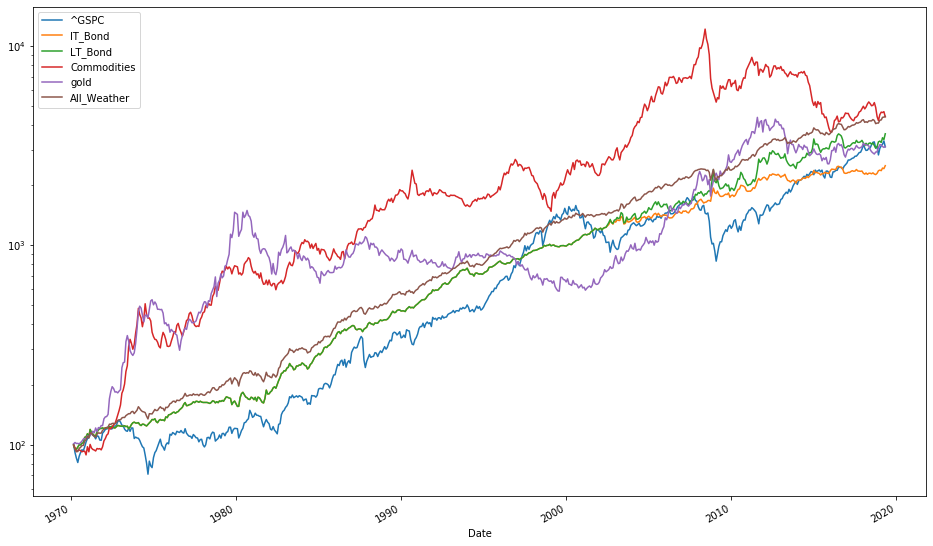

In [ ]:
estats.cum_returns(df_all, 100).plot.line(figsize=(16,10));
plt.yscale('log')

In [ ]:
df_pf.head()

,All_Weather
Date,
1970-03-01,-0.003392
1970-04-01,-0.052555
1970-05-01,-0.023227
1970-06-01,-0.000179
1970-07-01,0.036362


In [ ]:
df_pf.tail()

,All_Weather
Date,
2019-01-01,0.034060
2019-02-01,0.002787
2019-03-01,0.030557
2019-04-01,0.002469
2019-05-01,0.008918


### Tests

**Set up data**

In [ ]:
prices_6040 = tst_src.loadAllAdjustedPrices(['TLT', 'SPY'])
wr_6040 = period_returns_from_prices(prices_6040, wr=True)

In [ ]:
wr_6040.head()

,TLT,SPY
Date,,
2017-04-10,1.025030,0.988563
2017-04-17,1.000567,1.008946
2017-04-24,0.990368,1.014877
2017-05-01,0.991336,1.006804
2017-05-08,1.002915,0.996996


In [ ]:
# assume a rebalance period of 3
# For interest, choose a short period of high volatility
test_6040 = wr_6040.loc['2020-02-17':'2020-03-30']
test_6040

,TLT,SPY
Date,,
2020-02-17,1.024144,0.987796
2020-02-24,1.049108,0.888389
2020-03-02,1.073788,1.004050
2020-03-09,0.924431,0.905399
2020-03-16,1.035663,0.849547
2020-03-23,1.051872,1.114118
2020-03-30,1.004771,0.979362


In [ ]:
#hide
# Frozen display of value used in test
test_6040

,TLT,SPY
Date,,
2020-02-17,1.024144,0.987796
2020-02-24,1.049108,0.888389
2020-03-02,1.073788,1.004050
2020-03-09,0.924431,0.905399
2020-03-16,1.035663,0.849547
2020-03-23,1.051872,1.114118
2020-03-30,1.004771,0.979362


In [ ]:
#hide
##
## Test pf_cum_wr_seq()
##

expected_py_array = array.array('d', [1.00233529086481, 0.9563036816433197, 0.9901485047549465, 0.9040172073166807, 0.8361477995951826, 0.9079644552327022, 0.8984541223283018])
assert pf_cum_wr_seq(test_6040, [0.4, 0.6], 3) == expected_py_array

In [ ]:
#hide
# test normalization of scaled weight list
assert pf_cum_wr_seq(test_6040, [0.8, 1.2], 3, normalize_wts=True) == expected_py_array

In [ ]:
#hide
#
# Test  pf_period_returns()
#

import empyrical.stats as estats

# note fractional returns, not wealth ratios
pf_return_df = pf_period_returns(test_6040, [0.4, 0.6], 3, 'My Portfolio')
assert list(estats.cum_returns(pf_return_df['My Portfolio'], starting_value=1)) == list(expected_py_array)

C:\Users\USER\anaconda3\envs\jptrlab-pip\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
#hide
# Validate we get the same results if we start computing the returns much earlier -- as long
# as the rebalance periods are aligned.
# skip the first two elements of wr_6040 -- rebalance times must align to get the same result
pf_period_returns(wr_6040.iloc[2:, :], [0.4, 0.6], 3, 'My Portfolio').loc['2020-02-17':].head(7)

,My Portfolio
Date,
2020-02-17,0.002335
2020-02-24,-0.045924
2020-03-02,0.035391
2020-03-09,-0.086988
2020-03-16,-0.075075
2020-03-23,0.085890
2020-03-30,-0.010474


**Test computePortfolioReturns()**

In [ ]:
#hide
# computePortfolioValues(asset_weights, pf_name, rebal_period, period='weekly',start_date='2017-05-01', normalize_wts=False):
cpv_df = computePortfolioReturns(tst_src, {'SPY':0.60, 'TLT': 0.40}, "MyPf", 3, start_date='2020-02-17')
assert (cpv_df.iloc[:7,:].values == pf_return_df.values).all()
cpv_df.head(7)

,MyPf
Date,
2020-02-17,0.002335
2020-02-24,-0.045924
2020-03-02,0.035391
2020-03-09,-0.086988
2020-03-16,-0.075075
2020-03-23,0.085890
2020-03-30,-0.010474


In [ ]:
#hide
# Verify the `wr` parameter works as intended
cpv_df_wr = computePortfolioReturns(tst_src, {'SPY':0.60, 'TLT': 0.40}, "MyPf", 3, start_date='2020-02-17', wr=True)
assert((cpv_df.values + 1 == cpv_df_wr.values).all())
cpv_df_wr.head(7)

,MyPf
Date,
2020-02-17,1.002335
2020-02-24,0.954076
2020-03-02,1.035391
2020-03-09,0.913012
2020-03-16,0.924925
2020-03-23,1.085890
2020-03-30,0.989526


## Notebook Export

In [ ]:
#hide
notebook2script()

Converted 00_core.ipynb.
Converted 01_Stats.ipynb.
Converted index.ipynb.
